# Schraubenerkenner

In [1]:
# Importe
import cv2
import numpy as np

# Da cv2.imshow() nicht in einer jupyter-Umgebung funktioniert, müssen die Ausgaben per matplotlib erfolgen
from matplotlib import pyplot as plt

# Helfer damit die Schraubeninformationen angezeigt werden können
import pandas as pd

# Helfer um das zusammenfügen von Pfaden zu vereinfachen
from pathlib import Path

Bilder liegen in dem Unterverzeichnis "images", "{EAN}", "{Bildbezeichnung}.jpg"

Hier wird eines eingelesen und angezeigt:

True

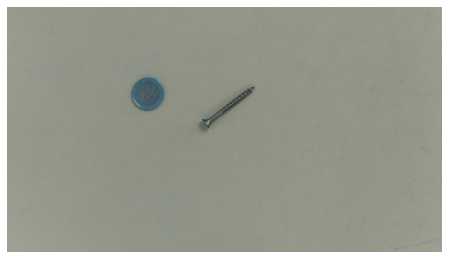

In [2]:
filepath = ("images", "4003530091896", "WIN_20220507_11_56_55_Pro.jpg") # Gute Ergebnisse
# filepath = ("images", "4003530097096", "WIN_20220507_12_18_11_Pro.jpg") # Ok Ergebnisse
# filepath = ("images", "4003530157042", "WIN_20220507_12_00_13_Pro.jpg") # Gute Ergebnisse
# filepath = ("images", "4003530166181", "WIN_20220507_12_13_07_Pro.jpg") # Schlechte Ergebnisse
# filepath = ("images", "4003530166297", "WIN_20220507_12_02_38_Pro.jpg") # Schlechte Ergebnisse
# filepath = ("images", "4003530166297", "WIN_20220507_12_02_42_Pro.jpg") # Schlechte Ergebnisse
# filepath = ("images", "4003530166327", "WIN_20220507_12_15_34_Pro.jpg") # Schlechte Ergebnisse

EAN = filepath[1]
filepath = str(Path(*filepath))
image_base = cv2.imread(filepath)

plt.figure(figsize=(8,4.5))
plt.axis("off")
plt.imshow(image_base)
cv2.imwrite("image_base.png", image_base)

Der erste Verarbeitungsschritt ist das Umwandeln in ein Graustufenbild, damit die Pixel im nächsten schritt Kategorisiert werden können.

True

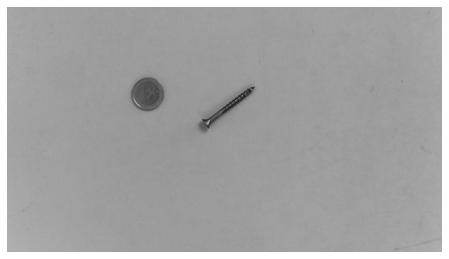

In [3]:
image_gray=cv2.cvtColor(image_base, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8,4.5))
plt.axis("off")
plt.imshow(image_gray, cmap="gray")
cv2.imwrite("image_gray.png", image_gray)

Folgend die binäre Aufteilung des Bildes in schwarze und weiße Pixel - dies ist für das Erkennen der Kanten, und somit auf dem Bild vorhandenen Formen notwendig.

True

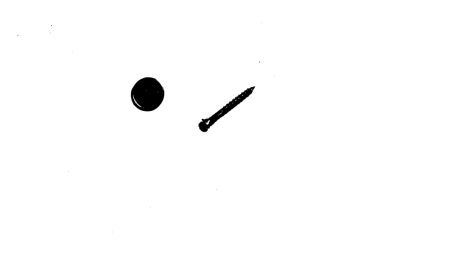

In [4]:
_, image_threshold=cv2.threshold(image_gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

plt.figure(figsize=(8,4.5))
plt.axis("off")
plt.imshow(image_threshold, cmap="gray")
cv2.imwrite("image_threshold.png", image_threshold)

True

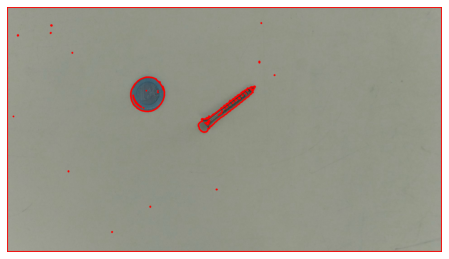

In [5]:
contours_all, _ = cv2.findContours(image_threshold, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

image = image_base.copy()
cv2.drawContours(image, contours_all, -1, (255, 0, 0), 5)

plt.figure(figsize=(8,4.5))
plt.axis("off")
plt.imshow(image)
cv2.imwrite("image_contours_all.png", image)

Wie auf dem Bild oben zu sehen ist, wurden neben der Münze und der Schraube auch weitere bedeutungslose Flecken entdeckt - damit sie das Ergebnis nicht stören, müssen sie entfernt werden. Zusätzlich wurde auch noch ein Rahmen um das gesamte Bild gezogen.

Um diese beiden Konturen zu entfernen, müssen 2 Regeln eingeführt werden:
- Winzige Flächen werden entfernt (kleiner als 0.1 % des Pixelvolumens)
- Gigantische Flächen müssen entfernt werden (größer als 25 % des Pixelvolumens)

Anzahl der verbleibenden Flächen: 2


<ipython-input-6-22105a46fadc>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours_reduced.remove(contour)


True

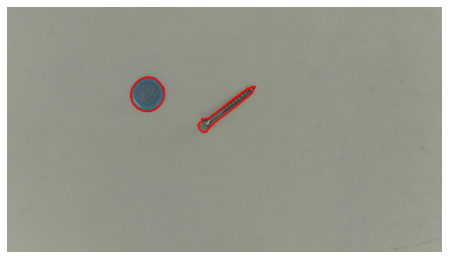

In [6]:
# TODO: Die Berechnung für die Flächen ist komisch, die Münze / Schrauben nehmen doch bestimmt mehr als 0.x % der Fäche ein
min_area = (image_base.shape[0] * image_base.shape[1]) // 1000
max_area = (image_base.shape[0] * image_base.shape[1]) // 4
contours_reduced = contours_all.copy()

for i, contour in enumerate(contours_reduced.copy()):
    contour_area=cv2.contourArea(contour)
    # TODO: Remove line
    # print(contour_area)
    if contour_area < min_area or contour_area > max_area:
        contours_reduced.remove(contour)

print(f"Anzahl der verbleibenden Flächen: {len(contours_reduced)}")
# TODO: Remove line
# print(min_area, max_area)
image = image_base.copy()
cv2.drawContours(image, contours_reduced, -1, (255, 0, 0), 5)

plt.figure(figsize=(8,4.5))
plt.axis("off")
plt.imshow(image)
cv2.imwrite("image_contours_reduced.png", image)

Nachdem die Auswahl der möglichen Objekte jetzt stark reduziert wurde, muss die Münze erkannt und aus dem Schraubenpool entfernt werden.
Dazu werden sämtliche Konturen nach dem kleinst möglichen Rechteck untersucht und das ausgewählt, welches am nächsten zu einem Seitenverhältnis von 1 kommt.

Weiterhin wird noch die Pixelgröße auf dem Bild errechnet.
Dies erfolgt Anhand der kürzesten Kante des kleinstmöglichen Rechtecks, da diese dem Durchmesser der Münze entsprechen sollte.

In [7]:
ratios = list()
for contour in contours_reduced:
    rect = cv2.minAreaRect(contour)

    # Kantenlängen können nicht negativ sein, also können sie sicher zum dividieren verwendet werden.
    aspect_ratio = rect[1][0] / rect[1][1]

    # Distanz zu 1 berechnen
    ratios.append(abs(aspect_ratio - 1))

# Den kleinsten Abstand zu 1 Auswählen - die größe Ändert sich nicht Symmetrisch hin zu 1, 
# aber da die Münze immer sehr nah und Schrauben immer recht weit weg von diesem Verhältnis sein sollten, 
# sollte diese Rechnung in Ordnung sein.
smallest = min(ratios)
coin_index = ratios.index(smallest)

In [8]:
contours_screws = contours_reduced.copy()

coin = contours_screws.pop(coin_index)
coin_box = cv2.minAreaRect(coin)
coin_diameter = min(coin_box[1])
coin_diameter_mm = 23.25
coin_box = cv2.boxPoints(coin_box)
coin_box = np.intp(coin_box)

pixel_size = coin_diameter_mm / coin_diameter

print(f"Pixel size: {pixel_size:.2f}mm")

Pixel size: 0.16mm


Jetzt sollten nur noch Schrauben auf dem Bild verbleiben.
Die Münze ist mit einem gelben Rechteck markiert, die Schrauben mit blauen Konturen.

True

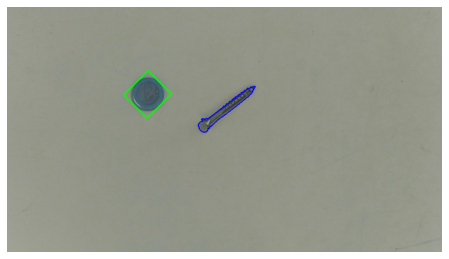

In [9]:
image = image_base.copy()
cv2.drawContours(image, contours_screws, -1, (255, 0, 0), 3)
cv2.drawContours(image, [coin_box], 0, (0, 255, 0), 5)

plt.figure(figsize=(8,4.5))
plt.axis("off")
plt.imshow(image)
cv2.imwrite("image_contours_coin.png", image)

Um die Identifizierung der einzelnen auf dem Bild enthaltenen Schrauben zu ermöglichen werden diese aus dem Bild extrahiert und einzeln weiterverarbeitet.

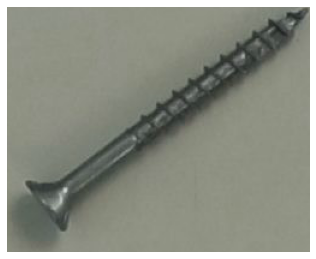

In [10]:
images_screws = list()

for contour in contours_screws:
    x, y, w, h = cv2.boundingRect(contour)
    screw = image_base[y:y+h, x:x+w]
    images_screws.append(screw)

old_contour = image[y:y+h, x:x+w]

plt.figure(figsize=(8,4.5))
plt.axis("off")
plt.imshow(images_screws[0])

Wie auf dem Bild ersichtlich ist, ist das kleinste "gerade" Rechteck noch zu groß um die Schraube zuverlässig zu erfassen.

Eine ausschlagkräftige Maßnahme ist die Entfernung der Schatten auf dem Bild, um die Kontur auf die Schraube zu reduzieren - dadurch kann dann endlich die Größe der Schraube gemessen werden.

<ipython-input-11-1ace952fc9e3>:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  screw_contours.remove(contour)


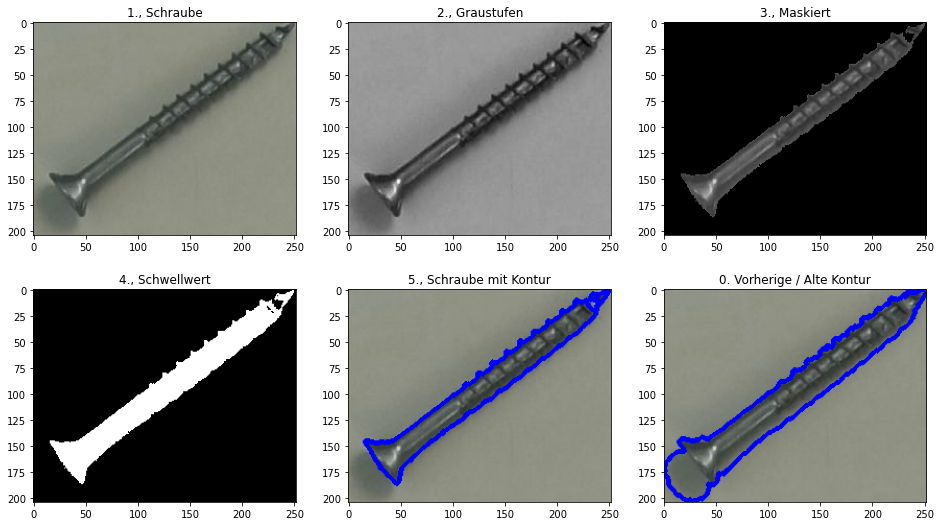

In [11]:
# Graustufen der Bilder erstellen
images_gray = list()
for image in images_screws:
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    images_gray.append(image)

# Masken für die Schraube berechnen, damit Schatten entfernt werden können
images_masked = list()
for image in images_gray:
    # Für die Maske ist ein 3-Kanal-Farbformat notwendig
    image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    blank_mask = np.zeros(image.shape, dtype=np.uint8)

    original = image.copy()
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Lower und Upper Bounds für die Maske definieren
    # Abhängig von deren Werten wird die Maske angeleget
    # Da das untere Ende bei 0 liegt (schwarz), werden dunkle Flächen immer aktzeptiert, es wird nur noch in den helleren Flächen unterschieden.
    lower = np.array([0]*3)
    # Das obere Ende definiert die erforderliche Helligkeit um zwischen Schraube und Schatten zu unterscheiden 
    # Der tatsächliche Wert ist von Schraube, Hintergrund und Beleuchtung abhängig.
    upper = np.array([90]*3)
    mask = cv2.inRange(hsv, lower, upper)

    # TODO: richtig schreiben
    # Das eigentliche Kontour-Finden entlang der Maske
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # TODO: Fragen was / warum da passiert
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    cv2.drawContours(blank_mask, cnts, 0, (255,)*3, -1)
    images_masked.append(
        cv2.bitwise_and(original, blank_mask)
    )

# Erstellen einer schwarz-weiß-Maske, welche definiert was innerhalb oder außerhalb der Schraube liegt
images_threshold = list()
for image in images_masked:
    result = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    _, result = cv2.threshold(result, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    images_threshold.append(result)

# Berechnen der Kontur, welche verwendet werden kann, um die Schraube aus dem Bild zu extrahieren.
images_contours = list()
for image in images_threshold:
    screw_contours, _ = cv2.findContours(image.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    min_area = (image.shape[0] * image.shape[1]) // 1000
    max_area = (image.shape[0] * image.shape[1]) // 4

    for i, contour in enumerate(screw_contours.copy()):
        contour_area=cv2.contourArea(contour)
        # TODO: Remove line
        # print(contour_area)
        if contour_area < min_area or contour_area > max_area:
            screw_contours.remove(contour)

    images_contours.append(screw_contours)




image = images_screws[0].copy()
contour = images_contours[0].copy()
cv2.drawContours(image, contour, -1, (0, 0, 255), 3, lineType=cv2.FILLED)



fig, axs = plt.subplots(2, 3, figsize=(16, 9))

index = 0
axs[0, 0].imshow(images_screws[index])
axs[0, 0].set_title("1., Schraube")

axs[0, 1].imshow(images_gray[index], cmap="gray")
axs[0, 1].set_title("2., Graustufen")

axs[0, 2].imshow(images_masked[index])
axs[0, 2].set_title("3., Maskiert")

axs[1, 0].imshow(images_threshold[index], cmap="gray")
axs[1, 0].set_title("4., Schwellwert")

axs[1, 1].imshow(image)
axs[1, 1].set_title("5., Schraube mit Kontur")

axs[1, 2].imshow(old_contour)
axs[1, 2].set_title("0. Vorherige / Alte Kontur")
None

Da jetzt die Kontur wie in Bild Nr. 5 zu sehen angepasst wurde, kann jetzt anhand derer die Größe der Schraube bestimmt werden:

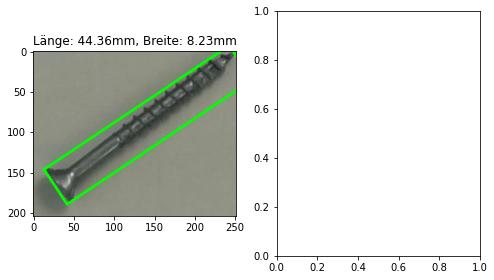

In [12]:
fig, axs = plt.subplots(len(images_contours), 2, figsize=(8, 4.5*len(images_contours)))

for i, screw in enumerate(images_contours):
    screw = screw.copy()
    rect = cv2.minAreaRect(screw[0])
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    image = images_screws[i].copy()
    cv2.drawContours(image, [box], 0, (0, 255, 0), 2)
    axs[i].imshow(image)
    axs[i].set_title(f"Länge: {rect[1][0]*pixel_size:.2f}mm, Breite: {rect[1][1]*pixel_size:.2f}mm")
    